# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 12)


positive    307061
negative     57110
Name: Score, dtype: int64

In [4]:
savetofile(final,"sample_svm")

In [5]:
final = openfromfile("sample_svm")

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"don't", 'did', 'each', 'mightn', 'so', 'll', 'below', 'himself', 'there', "doesn't", 'those', 'itself', 'its', 'an', 'between', 'off', 'where', 'ma', 'having', 'my', "haven't", 'i', 'me', 'their', 'both', 'when', 't', "you'll", 'isn', 'shouldn', 'for', 'if', 'why', 'theirs', 'through', 'been', 'by', 'couldn', 'she', "needn't", 'just', 'this', 're', 'can', 'm', "should've", 'should', "weren't", "hadn't", 'same', 'that', 'not', 'how', 'is', 'be', 'doing', 'wouldn', 'yours', 'once', 'of', "you'd", 'again', 'until', 'herself', 'but', 'now', 'too', 'at', "it's", 'only', 'in', 'd', 'themselves', "mightn't", "didn't", 'ours', 'as', "isn't", 'does', 'here', 'some', 'do', 'mustn', 'has', 'it', 'am', 'he', 'wasn', 'him', 'didn', 'weren', 'have', 'hasn', "mustn't", 'myself', 'yourself', 'shan', 'your', 'into', 'you', 'then', 'yourselves', 'a', "shan't", "you've", 'the', "she's", 'very', 'haven', 'while', 'won', 'further', 'above', 'these', 'after', 'few', 'whom', 'about', 's', 'with', 'any', 'b

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [9]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# [7.2.2] Bag of Words (BoW)

In [10]:
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254919, 12709)
the number of unique words : 12709


In [11]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

GridSearchCV Implementation

In [12]:
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.cross_validation import cross_val_score

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9206147255885476
The optimal value of alpha(1/C) is :  0.1


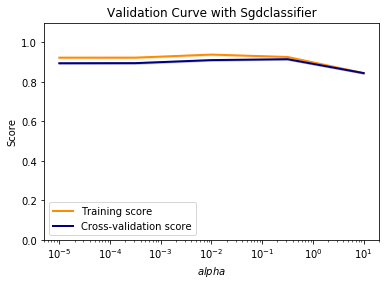

In [13]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  92.015707%
Confusion matrix for the model is:


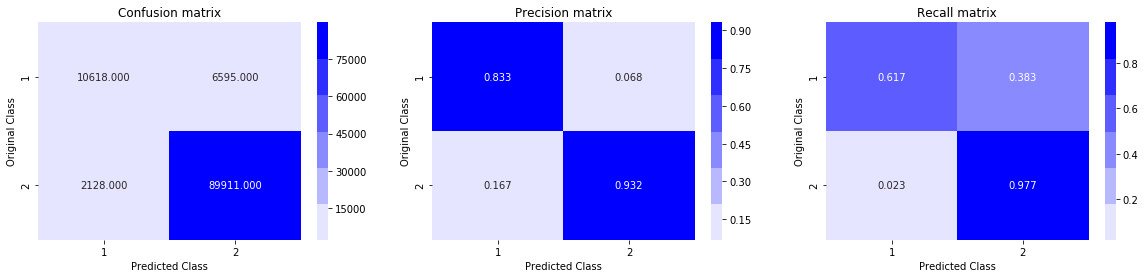

f1 score value for   the model is: 0.9201570680628273
precision score  for   the model is: 0.9316622800654881


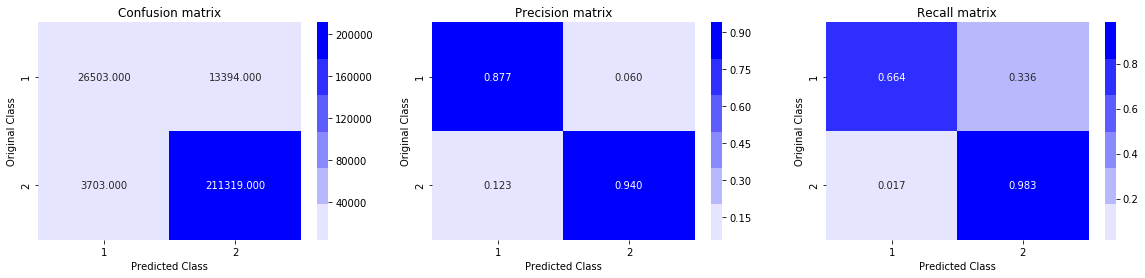

Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  93.293164%
f1 score value for   the model is: 0.9329316371082579
precision score  for   the model is: 0.9403950817264689


In [16]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)






Using Randomized Search CV to find best parameters

In [17]:
# Load libraries
from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.16020486875519047, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9184545820671475
The optimal value of alpha(1/C) is :  0.16020486875519047


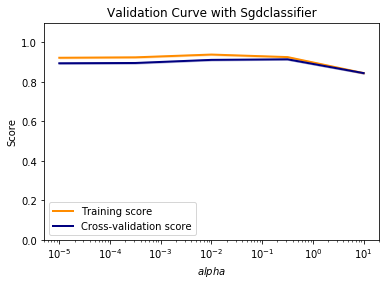

In [18]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.160205% is:  91.887563%
Confusion matrix for the model is:


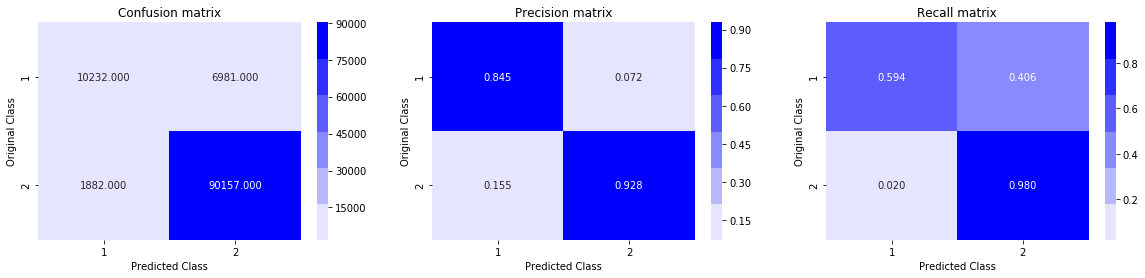

f1 score value for   the model is: 0.9188756269908103
precision score  for   the model is: 0.9281331713644506


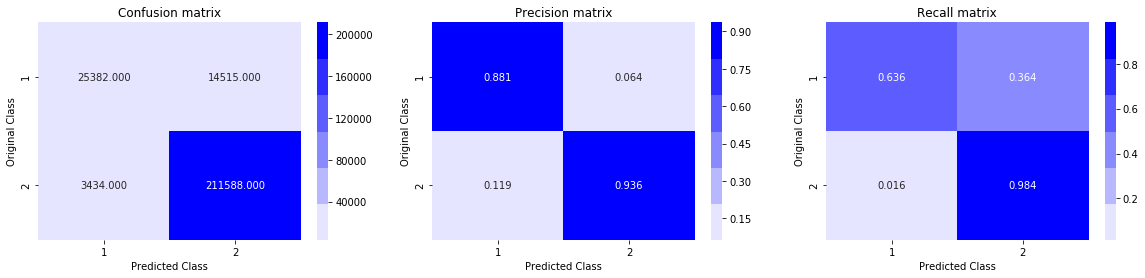

Accuracy of the model at optimal hyperparameter alpha = 0.160205% is:  92.958940%
f1 score value for   the model is: 0.9295893989855601
precision score  for   the model is: 0.9358035939372764


In [19]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

# [7.2.5] TF-IDF

In [20]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254919, 12709)
the number of unique words : 12709


GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [21]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9171548346941018
The optimal value of alpha(1/C) is :  0.1


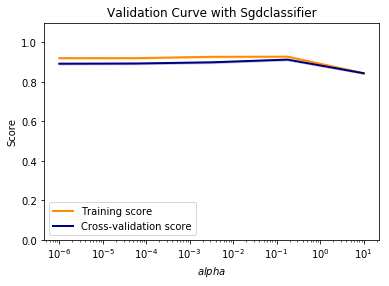

In [22]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  91.715483%
Confusion matrix for the model is:


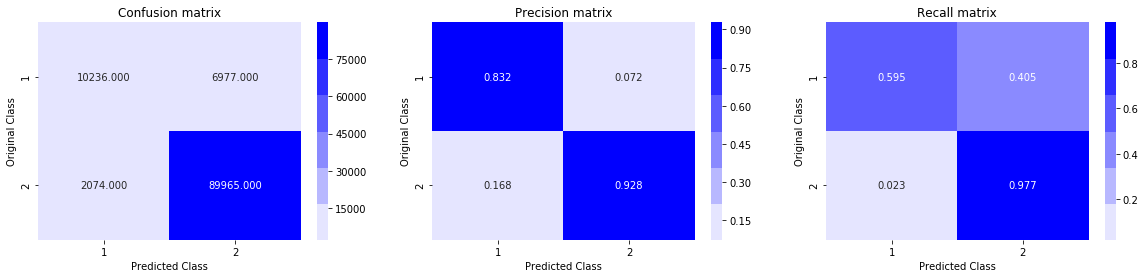

f1 score value for   the model is: 0.9171548346941018
precision score  for   the model is: 0.9280291308204907


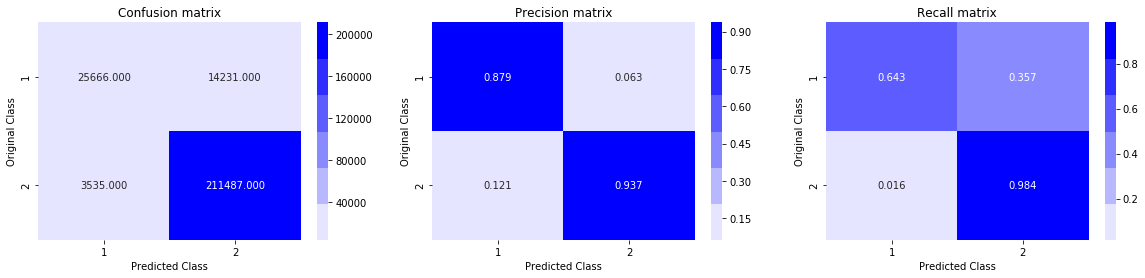

Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  93.030727%
f1 score value for   the model is: 0.9303072740752946
precision score  for   the model is: 0.9369523033165277


In [23]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

RandomizedSearchCV Implementation

In [24]:
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.08267522310434594, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9181159154981144
The optimal value of alpha(1/C) is :  0.08267522310434594


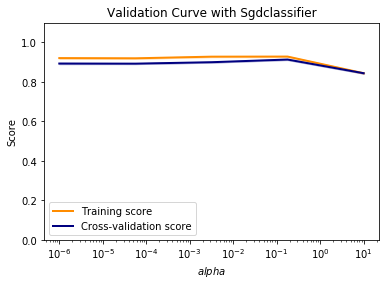

In [25]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.082675% is:  91.787793%
Confusion matrix for the model is:


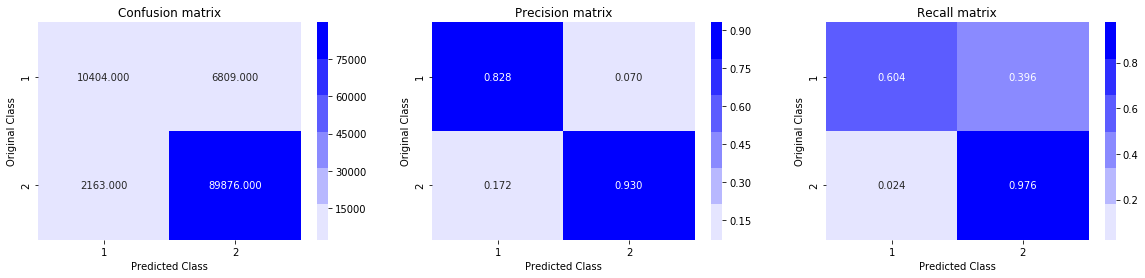

f1 score value for   the model is: 0.9178779335847399
precision score  for   the model is: 0.9295754253503646


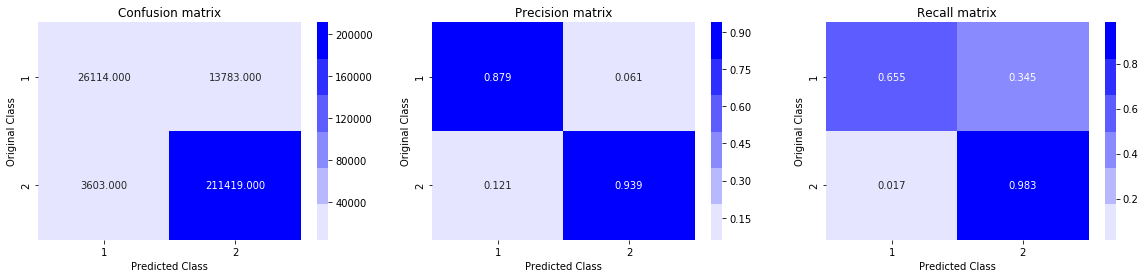

Accuracy of the model at optimal hyperparameter alpha = 0.082675% is:  93.179794%
f1 score value for   the model is: 0.9317979436605351
precision score  for   the model is: 0.938797168764043


In [26]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

# [7.2.6] Word2Vec

In [27]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [29]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [30]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21938
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


In [32]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8036037683486938),
 ('yummi', 0.7908559441566467),
 ('tastey', 0.7797962427139282),
 ('good', 0.7009510397911072),
 ('satisfi', 0.6824684739112854),
 ('nice', 0.6783034801483154),
 ('hearti', 0.6752885580062866),
 ('nutriti', 0.6638903617858887),
 ('great', 0.6362514495849609),
 ('terrif', 0.6349390745162964)]

In [33]:
w2v_model.wv.most_similar('like')

[('weird', 0.7421442270278931),
 ('dislik', 0.689490795135498),
 ('gross', 0.6681321859359741),
 ('resembl', 0.6628752946853638),
 ('prefer', 0.6582372784614563),
 ('okay', 0.6581045389175415),
 ('appeal', 0.6420395970344543),
 ('yucki', 0.6407833099365234),
 ('remind', 0.6362999677658081),
 ('funki', 0.6322592496871948)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [34]:
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  18755


In [35]:
from sklearn.preprocessing import StandardScaler
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

GridSearchCV Implementation

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8856209750801078
The optimal value of alpha(1/C) is :  0.001


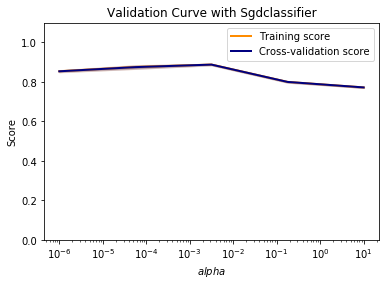

In [37]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
     scoring="f1_weighted", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.001000% is:  89.625819%
Confusion matrix for the model is:


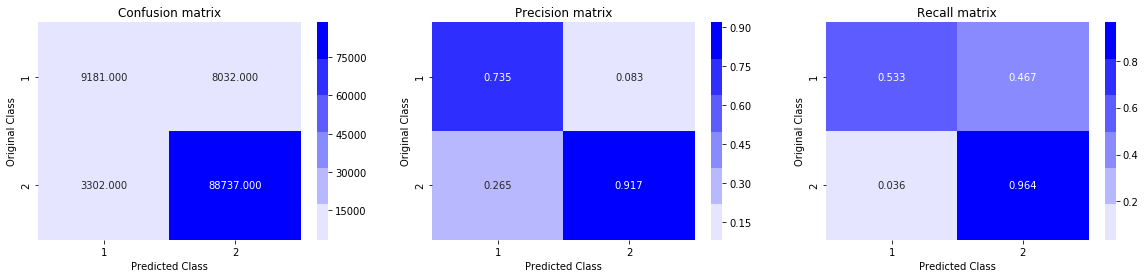

f1 score value for   the model is: 0.889295622531827
precision score  for   the model is: 0.9169982122373901


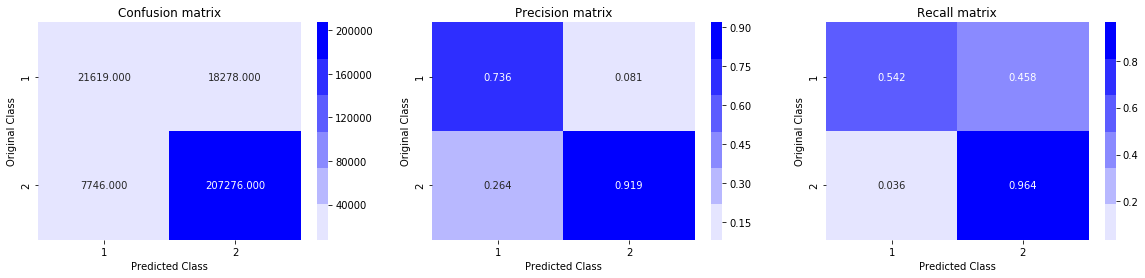

Accuracy of the model at optimal hyperparameter alpha = 0.001000% is:  89.791267%
f1 score value for   the model is: 0.8913711580437575
precision score  for   the model is: 0.9189639731505538


In [38]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

RandomizedSearchCV Implementation

In [39]:
from scipy.stats import uniform
# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'precision_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.059808907415042745, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8817504485043752
The optimal value of alpha(1/C) is :  0.059808907415042745


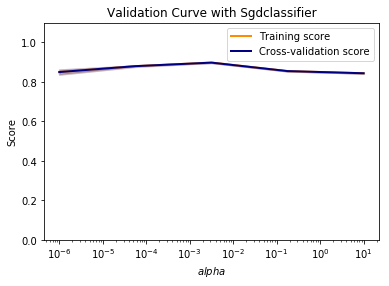

In [40]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
     scoring="precision_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.059809% is:  88.207996%
Confusion matrix for the model is:


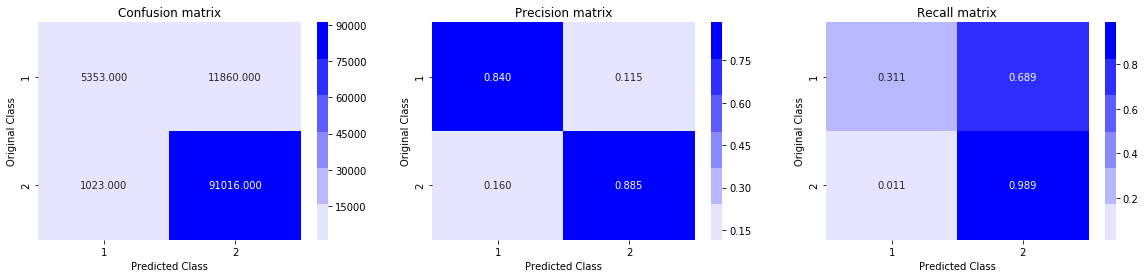

f1 score value for   the model is: 0.9339045224841598
precision score  for   the model is: 0.8820799619228938


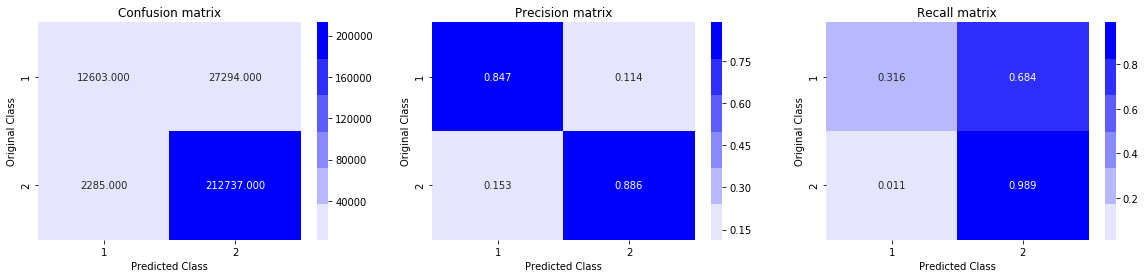

Accuracy of the model at optimal hyperparameter alpha = 0.059809% is:  88.396706%
f1 score value for   the model is: 0.934998780361848
precision score  for   the model is: 0.8839670640477956


In [41]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred,pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive',average='micro')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred,pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive',average='micro')
print('precision score  for   the model is: %s'% precisionscore)

# TF-IDF weighted Word2Vec

In [42]:
# We will collect different 50K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 
    
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)

(50000, 12)


In [43]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [53]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)

In [54]:
savetofile(X_train_vec_standardized,"tf_idf_Weighted_w2vec_train")

In [55]:
savetofile(X_test_vec_standardized,"tf_idf_Weighted_w2vec_test")

GridSearchCV Implementation

In [47]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.5794
The optimal value of alpha(1/C) is :  0.001


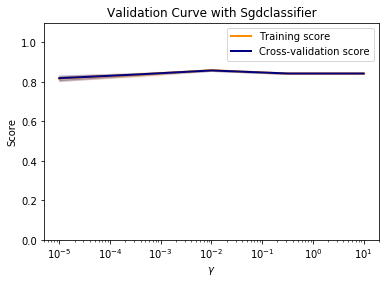

In [48]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.001000% is:  75.020000%
Confusion matrix for the model is:


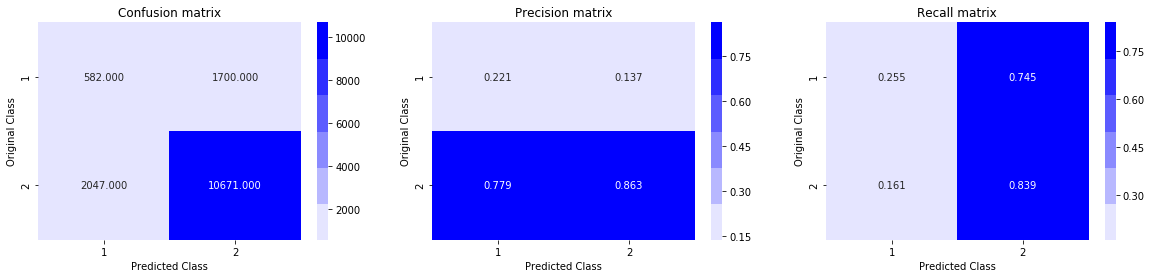

f1 score value for   the model is: 0.7502
precision score  for   the model is: 0.8625818446366502


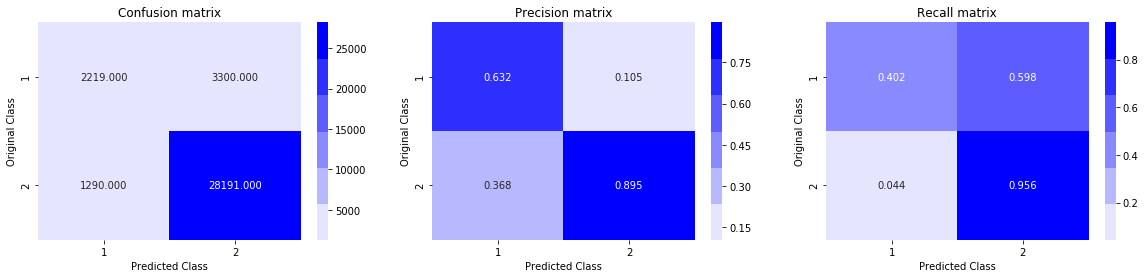

Accuracy of the model at optimal hyperparameter alpha = 0.001000% is:  86.885714%
f1 score value for   the model is: 0.868857142857143
precision score  for   the model is: 0.8952081547108698


In [49]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

RandomizedSearchCV Implementation

In [50]:
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.06728378524251355, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8306
The optimal value of alpha(1/C) is :  0.06728378524251355


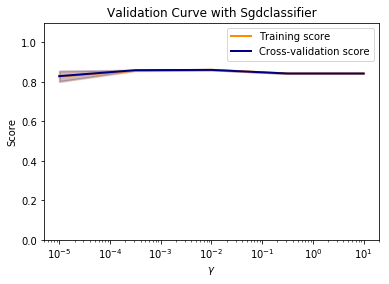

In [51]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.067284% is:  83.086667%
Confusion matrix for the model is:


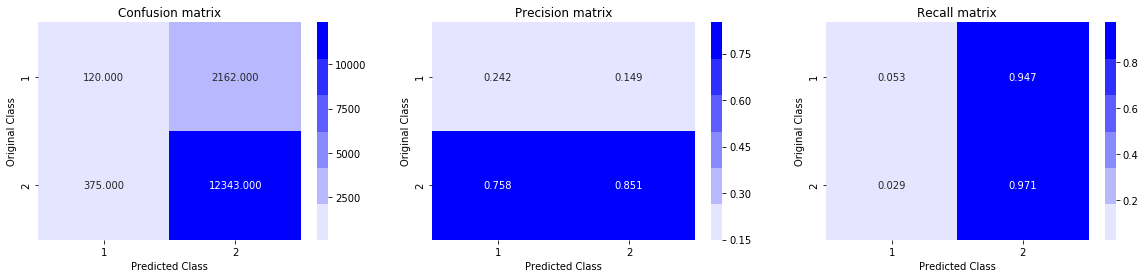

f1 score value for   the model is: 0.8308666666666666
precision score  for   the model is: 0.8509479489831093


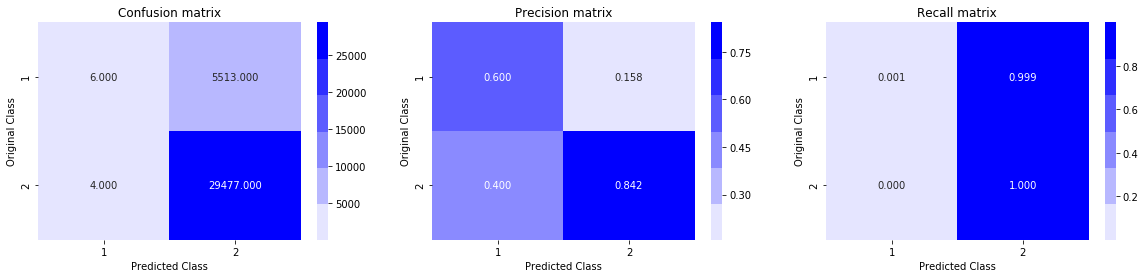

Accuracy of the model at optimal hyperparameter alpha = 0.067284% is:  84.237143%
f1 score value for   the model is: 0.8423714285714285
precision score  for   the model is: 0.8424406973420977


In [52]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

# Comparing "SGDClassifier with hinge-loss" and "SVC with RBF kernel" on a smaller sample for BoW vectorizer

In [11]:
# We will collect different 50K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print("Shape of my_final dataframe : ",my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#BoW (Bag of Words Vectorizer)
count_vect = CountVectorizer(min_df = 100) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

Shape of my_final dataframe :  (50000, 12)
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (35000, 1505)
the number of unique words : 1505


GridSearchCV Implementation

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9132666666666667
The optimal value of alpha(1/C) is :  0.1


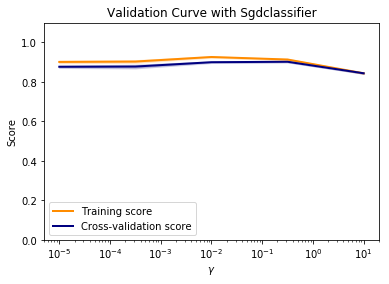

In [14]:


import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0 is:  91.246667%
Confusion matrix for the model is:


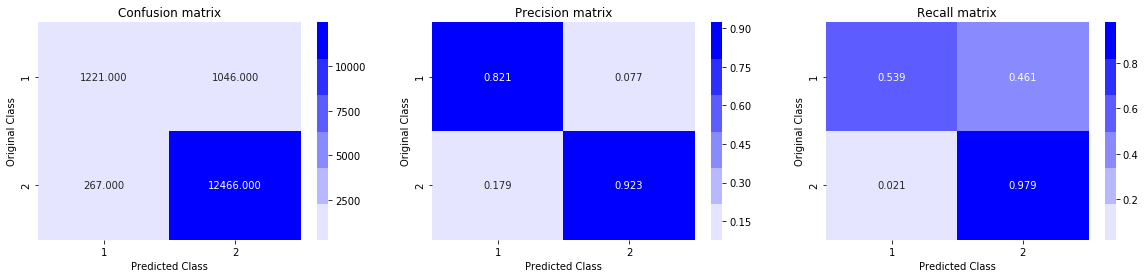

f1 score value for   the model is: 0.9499714231282148
precision score  for   the model is: 0.9225873297809355


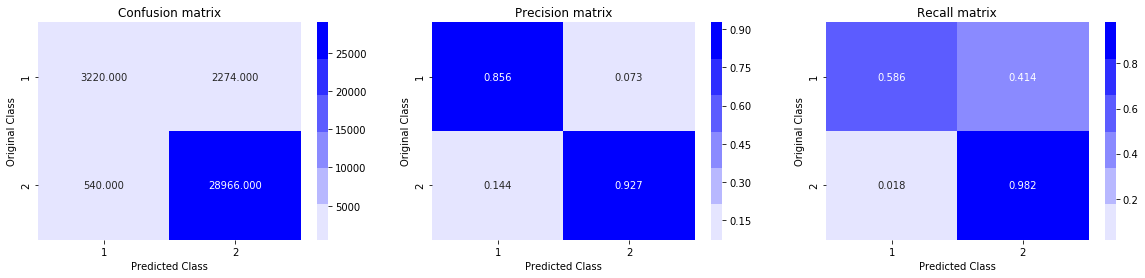

Accuracy of the model at optimal hyperparameter alpha = 0 is:  91.960000%
f1 score value for   the model is: 0.9536759622032727
precision score  for   the model is: 0.9272087067861716


In [17]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

GridSearchCV Implementation SVC with RBF kernel

In [18]:
from sklearn.svm import SVC

C_range = [1,2,4,8,16,32]

param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

# SVC with RBF kernel with Optimal value of C
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized,Y_train)
predictions = svc.predict(X_test_vec_standardized)

Model with best parameters :
 SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.9099333333333334
The optimal value of C is :  4


Accuracy of the model at optimal hyperparameter alpha = 0 is:  91.533333%
Confusion matrix for the model is:


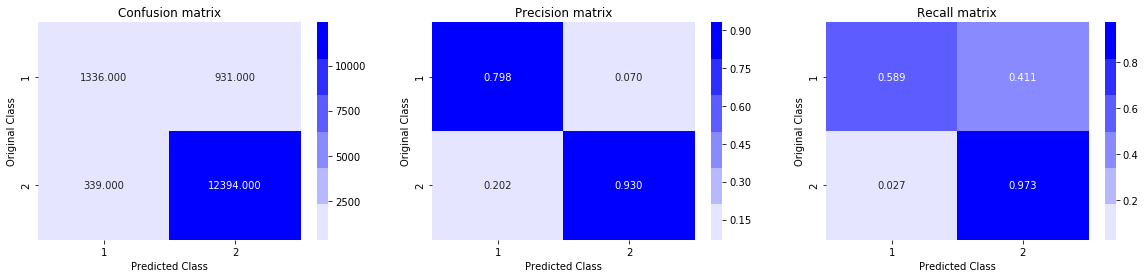

f1 score value for   the model is: 0.9512625681172768
precision score  for   the model is: 0.9301313320825516


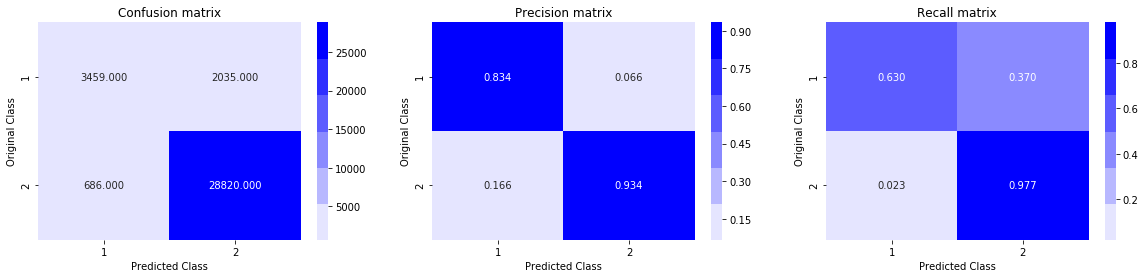

Accuracy of the model at optimal hyperparameter alpha = 0 is:  92.225714%
f1 score value for   the model is: 0.9549212239691192
precision score  for   the model is: 0.9340463458110517


In [19]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)

In [56]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words ','Bag of Words','Tf-Idf ',\
                 'Tf-Idf ','Avg word 2 vec ','Avg word 2 vec ',\
                 'TFIDF weighted w2vec ','TFIDF weighted w2vec ']


# Training accuracies
accuracy = [92.01,91.88,91.71,91.78,89.62,88.20,75.02,83.08]
F1score = [0.9201,0.9188,0.9171,0.9178,0.8892,0.9339,0.7502,0.8308]
precision=[0.9316,0.9281,0.9280,0.9295,0.9169,0.8820,0.8925,0.8509]
alpha=[0.10,0.16,0.10,0.08,0.001,0.05,0.001,0.06]
numbering = [1,2,3,4,5,6,7,8]
method=['gridsearch','randomsearch','gridsearch','randomsearch','gridsearch','randomsearch','gridsearch','randomsearch']
scoring=['f1_micro','f1_micro','f1_micro','f1_micro','f1_weighted','precision_micro','f1_micro','f1_micro']
# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("method",method)
ptable.add_column("scoring",scoring)
ptable.add_column("accuracy",accuracy)
ptable.add_column("F1 score",F1score)
ptable.add_column("precision",precision)

# Printing the Table
print(ptable)

+-------+-----------------------+--------------+-----------------+----------+----------+-----------+
| S.NO. |         MODEL         |    method    |     scoring     | accuracy | F1 score | precision |
+-------+-----------------------+--------------+-----------------+----------+----------+-----------+
|   1   |     Bag of Words      |  gridsearch  |     f1_micro    |  92.01   |  0.9201  |   0.9316  |
|   2   |      Bag of Words     | randomsearch |     f1_micro    |  91.88   |  0.9188  |   0.9281  |
|   3   |        Tf-Idf         |  gridsearch  |     f1_micro    |  91.71   |  0.9171  |   0.928   |
|   4   |        Tf-Idf         | randomsearch |     f1_micro    |  91.78   |  0.9178  |   0.9295  |
|   5   |    Avg word 2 vec     |  gridsearch  |   f1_weighted   |  89.62   |  0.8892  |   0.9169  |
|   6   |    Avg word 2 vec     | randomsearch | precision_micro |   88.2   |  0.9339  |   0.882   |
|   7   | TFIDF weighted w2vec  |  gridsearch  |     f1_micro    |  75.02   |  0.7502  |   